## Import

In [1]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

## Data Load

In [3]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

Dataset Info.

##### train.csv [파일]  
PRODUCT_ID : 제품의 고유 ID  
Y_Class : 제품 품질 상태(Target)   
0 : 적정 기준 미달 (부적합)  
1 : 적합  
2 : 적정 기준 초과 (부적합)  
Y_Quality : 제품 품질 관련 정량적 수치  
TIMESTAMP : 제품이 공정에 들어간 시각  
LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)  
PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)  
X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수  
  
  
##### test.csv [파일]  
PRODUCT_ID : 제품의 고유 ID  
TIMESTAMP : 제품이 공정에 들어간 시각  
LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)  
PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)  
X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수  
  
  
sample_submission.csv [파일] - 제출 양식  
PRODUCT_ID : 제품의 고유 ID  
Y_Class : 예측한 제품 품질 상태  
0 : 적정 기준 미달 (부적합)  
1 : 적합  
2 : 적정 기준 초과 (부적합)  
  
실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)  
'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.  

In [4]:
train_df.shape

(598, 2881)

In [5]:
train_df.describe()

,Y_Class,Y_Quality,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,598.000000,598.000000,349.000000,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.000000,...,100.000000,100.00000,100.000000,100.000000,100.00000,99.0,0.0,0.0,0.0,0.0
mean,1.025084,0.530896,2.409742,95.123209,0.0,45.0,10.392550,0.0,48.802292,10.048711,...,50.807300,53.60770,49.606200,51.659800,66.64970,1.0,NaN,NaN,NaN,NaN
std,0.565069,0.007401,5.895256,4.107640,0.0,0.0,0.489019,0.0,4.373824,0.215571,...,7.011828,8.13899,7.158917,8.913065,4.52781,0.0,NaN,NaN,NaN,NaN
min,0.000000,0.500856,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,32.120000,31.70000,32.560000,30.490000,61.67000,1.0,NaN,NaN,NaN,NaN
25%,1.000000,0.527535,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,49.485000,52.20000,42.160000,49.915000,63.64500,1.0,NaN,NaN,NaN,NaN
50%,1.000000,0.530436,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,...,53.425000,55.92500,51.460000,56.175000,65.14000,1.0,NaN,NaN,NaN,NaN
75%,1.000000,0.533433,2.000000,98.000000,0.0,45.0,11.000000,0.0,51.000000,10.000000,...,55.287500,58.97500,55.030000,57.175000,67.11500,1.0,NaN,NaN,NaN,NaN
max,2.000000,0.578841,103.000000,102.000000,0.0,45.0,11.000000,0.0,62.000000,11.000000,...,60.240000,68.66000,60.410000,59.930000,79.75000,1.0,NaN,NaN,NaN,NaN


In [ ]:
train_df['Y_Class'].hist()

In [ ]:
train_df

In [6]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

## Data Pre-processing

In [7]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [8]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


In [15]:
train_x.shape

(598, 2877)

## Classification Model Fit

In [9]:
RF = RandomForestClassifier(random_state=37).fit(train_x, train_y)
print('Done.')

Done.


# Feature importance

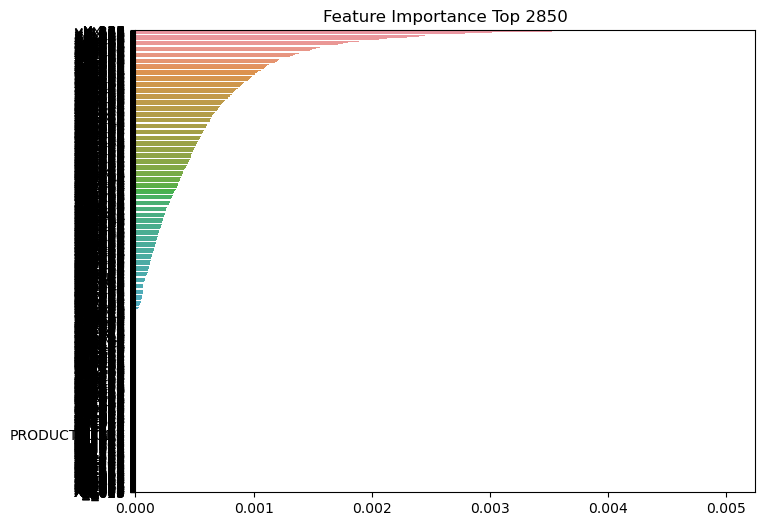

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

ft_importance_values = RF.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = train_x.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:2850]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 2850')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

## Inference

In [10]:
preds = RF.predict(test_x)
print('Done.')

Done.


## Submit

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit['Y_Class'] = preds

In [ ]:
submit.to_csv('./baseline_submission.csv', index=False)